# 🤒 Epidemic mitigation project - environment tutorial

This notebook is a tutorial on how to interact with the *epidemic simulation environment* provided for the miniproject.

## Installing the environment

1. Install conda if you don't have it (see [the conda documentation here](https://conda.io/projects/conda/en/latest/user-guide/install/index.html) to learn how to do so)
2. Create a dedicated environment and install the packages in the environment by running the following commands:
```
conda create -n epi
conda activate epi
conda install pytorch torchvision torchaudio -c pytorch
conda install numpy networkx matplotlib pyyaml jupyter tqdm pandas
pip install gym
```

### Importing the relevant packages
If the environment is correctly setup you should be able to sucessfully import the following packages.

In [1]:
import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn

%matplotlib inline

### Loading the environment object and running it
In the following cell we instanciate a dynamical model (of the `ModelDynamics` class) that implements the epidemic simulation. The simulation parameters are set by the config file that we load (here `switzerland.yaml`). We then demonstrate how one can query the list of cities from the dynamical model and how one can plot the map on which the simulation will happen. 

['Lausanne', 'Geneva', 'Sion', 'Neuchâtel', 'Basel', 'Bern', 'Lücern', 'St-Gallen', 'Zürich']


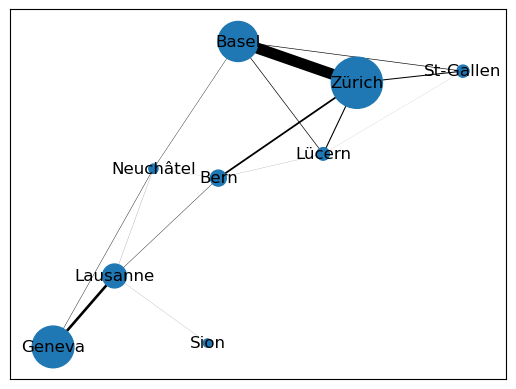

In [2]:
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map
print(dyn.cities)
dyn.draw_map()

The size of the dots represents the population in each city, the width of the connecting edges represents how fast contamination can propagate to one city to the next. 

### Instanciating the environment object
The environment provides a wrapper for an agent to interact with. It implements a step method that allows an agent to make observations and pick actions that will impact the environment. We show how to reset the environment (which is also the procedure used for initialization and for *seeding* the random number generators).

In [124]:
"""Loading the environment"""
env = Env(  dyn, # We pass the dynamical model to the environment (to create the results we need to return)
            action_space=None, # Here one could pass an openai gym action space that can then be sampled
            observation_space=None, # Here one could pass an openai gym obs space that can then be sampled
            )

# If we set action_space to be None, we can only use dictionaries as actions (sine we have not defined a mapping to scalar values)

""" Resetting the environment """
obs, info = env.reset(seed=0) # We pass a seed to the env to ensure reproductibility 


### Stepping throught the environment
Actions are passed to the environment as a dictionary of booleans. In the following cell we create an example `null` action.

In [125]:
action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }

Now that we have an action dictionary, we can pass it to the environment and perform an environment *step*.

In [126]:
"""One step amounts to one week in the simulation environment"""
obs, reward, done, info = env.step(action) # reward is not the constant reward but it considers all the other terms

At each step the environment returns four variables :
1. An observation `obs` (to be used by the agent for decision making)
2. A reward `rew` (to be used for training)
3. A boolean variable `done` (indicates when an episode is finished)
4. An information object `info` (to be used for policy interpretation and debugging)

we will now show in details what each of those variables contain.

#### Reading the observations object
The observation object is a dataclass containing all the information that the agent is allowed to access to make its decisions. In the following cells we show how to access the data in the observation object. 

The `pop` attribute of the observation gives the full population of each city (before the epidemic started). This is meant to be used to scale the observations when feeding them to a neural network. The `pop` attribute is a dictionary with string keys and int values.

In [43]:
print("Full population")
print(f"     {obs.pop}")
obs.pop

Full population
     {'Lausanne': 295000, 'Geneva': 900000, 'Sion': 34978, 'Neuchâtel': 44531, 'Basel': 830000, 'Bern': 133115, 'Lücern': 82000, 'St-Gallen': 76213, 'Zürich': 1354000}


{'Lausanne': 295000,
 'Geneva': 900000,
 'Sion': 34978,
 'Neuchâtel': 44531,
 'Basel': 830000,
 'Bern': 133115,
 'Lücern': 82000,
 'St-Gallen': 76213,
 'Zürich': 1354000}

When iterating through cities, it is useful to have a full list of the cities. Such a list can be accessed through the dynamical model object `dyn.cities` attribute. Below we print the population of each city using that method.

In [45]:
print('Initial population in each city:')
for c in dyn.cities:
    print(f"     {c} : {obs.pop[c]}")

Initial population in each city:
     Lausanne : 295000
     Geneva : 900000
     Sion : 34978
     Neuchâtel : 44531
     Basel : 830000
     Bern : 133115
     Lücern : 82000
     St-Gallen : 76213
     Zürich : 1354000


The `total` attribute gives the number of infected and dead people in the entire country. This is measured for each day of the week SINCE THE BEGINNING, OR JUST THIS WWEK? DEATHS = ACCUMULATED OVER THE WEEK?   # TODO. Below we get the total observation and then use it to plot the infected and death counts evolution for the week.

### Answer:
Deaths and infections, at the beginning of a given week, are measured starting from the amount of deaths and infectinos observed at the end of the previous week. So they are accumulated over weeks. Moreover, inside every week, deaths and infections are cumulated.

Full country observation
     Observables(infected=[13630, 30159, 53154, 74661, 54006, 27334, 41089], dead=[99858, 100058, 101601, 103762, 113657, 115375, 116486])


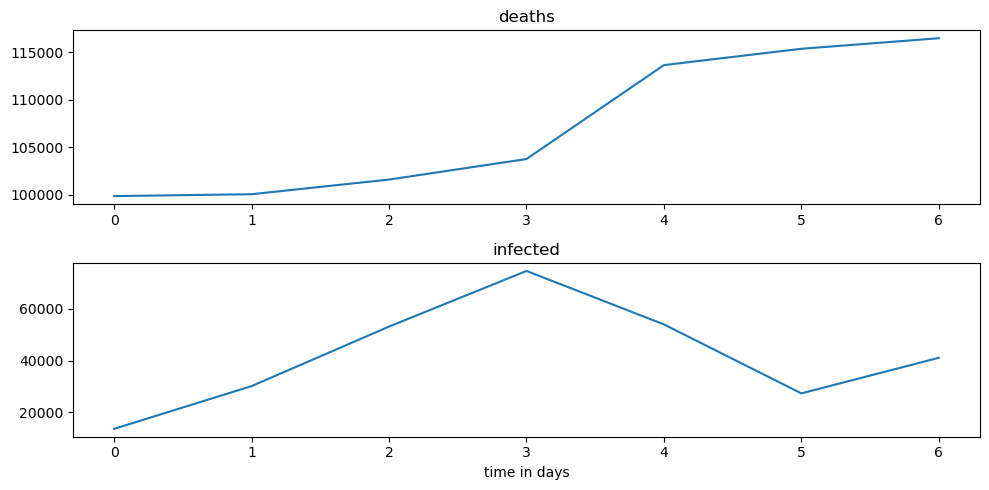

In [46]:
print("Full country observation")
print(f"     {obs.total}")
fig, ax = plt.subplots(2,figsize=(10,5))
ax[0].plot(obs.total.dead)
ax[0].set_title('deaths')
ax[1].plot(obs.total.infected)
ax[1].set_title('infected')
ax[1].set_xlabel('time in days')
fig.tight_layout()
plt.show()

The `city` attribute contains a dictionnary that allows acessing each city's number of infected and dead people. Each element of that dict is structured exactly as the `total` attribute is structured.

In [48]:
print("Lausanne's observation")
print(f"     {obs.city['Lausanne']}")

Lausanne's observation
     Observables(infected=[2827, 8438, 7421, 14261, 6477, 14055, 5653], dead=[1732, 1772, 2443, 2670, 3697, 4303, 4870])


#### Reading the informations object
The information object is a dataclass object that contains the most important parameters of the dynamical system as it unfolds. In the following cells we show how to read its content for plotting, analysing and debugging.

Unlike the observation dictionary, the information dictionnary contains the actions that were taken during the past week. They can be recovered as follows:

In [49]:
info.action #actions taken in the previous week (of which we have observed the data).

{'confinement': False,
 'isolation': False,
 'vaccinate': False,
 'hospital': False}

Then the information object contains `info.total` and `info.city` attributes (which as structured in a similar way to how the `obs.total` and `obs.city` (the city attribute is a dict, the total attribute contains the value for the full country). 

Unlike the observation attribute the information contains *all simulation variables* but *only on the last day of the week*.

In [50]:
info.total

Parameters(day=70, suceptible=279630, exposed=552541, infected=41089, recovered=2783369, dead=116486, initial_population=3749837)

Similarily, one can access the attributes for one specific city (here the number of recovered people in Bern) as follows:

In [51]:
info.city['Bern'].recovered 

122126

## Implementing an example agent, going through an entire episode
The following section shows how to implement a dummy agent. It introduces the action and observation preprocessors. We recommand that you subclass the example `Agent` class that is provided with the environment. Because the most efficient way to represent actions for a neural network is not the clearest way to represent actions for the environment, we recommand working with *action preprocessors* and *observation preprocessors*. The following cells detail how to implement them.

![](figures/preprocessing.png)

Properly defining the action and observation spaces will allow us to sample random actions, observations from them easily. This will be useful to automatically define the size of our neural networks, and to implement epsilon-greedy exploration schemes. In order to better understand the action and observation space, read the corresponding sections in the [OpenAI Gym Documentation](https://www.gymlibrary.dev/). 

sampled action : 3
Sampled observation


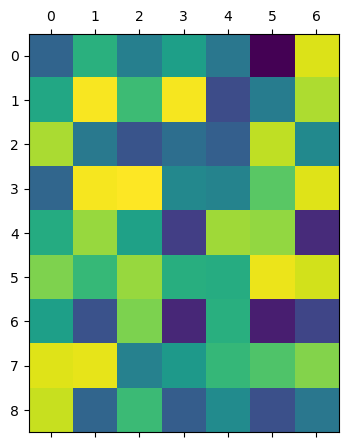

In [166]:
action_space        =   spaces.Discrete(5) 
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
print(f"sampled action : {action_space.sample()}")
print("Sampled observation")
plt.matshow(observation_space.sample()[0,:,:]) # we visualize data for each day in each city
plt.show()


In the following cell we implement preprocessing functions for actions and observations. The action preprocessing function takes an int and returns an action dictionary. The observation preprocessing function takes an observation object, and returns a torch tensor.

In [133]:
SCALE = 100
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4


def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True
        
    return action
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities]) #dead?
    confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    return torch.Tensor(np.stack((infected, dead, confined))).unsqueeze(0)

In the following cell we **instanciate an environment with set action and observation spaces attributes**. This will allow for sampling the env for example actions and observations, which we use for random actions in the example dummy agent. The action preprocessor and the observation preprocessor that we defined below are also passed to the environment.

In [184]:
env = Env(  dyn,
            action_space=action_space,
            #observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

# We can now use both a number or a dictionary as an action (see preprocessor implementation) and the observation is
# now a tensor

In the following cell we show how to subclass the agent class. (Here to create a fully random dummy agent with 5 actions).

In [114]:
class ExampleAgent(Agent): #superclass
    def __init__(self,  env:Env,
                # Additionnal parameters to be added here
                ):
        """
        Example agent implementation. Just picks a random action at each time step.
        """
        self.env = env
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    def act(self, obs):
        # this takes an observation and returns an action
        # the action space can be directly sampled from the env
        return self.env.action_space.sample() 

#### Running through an episode with the dummy agent
The following cell provides an example of going through an entire episode while logging the information dictionary as it is produced.

In [188]:
agent = ExampleAgent(env)

""" Run the simulation """
log = []
finished = False
obs, info = env.reset(2) # initialization (random infection)
agent.reset()
agent.epsilon = 0 #taken from Agent, which is superclass
while not finished:
    action = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break
    

""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

# all data at the end of the episode divided in weeks


In the following cell we provide an example of plotting an episode, from the log dictionnaries defined above.

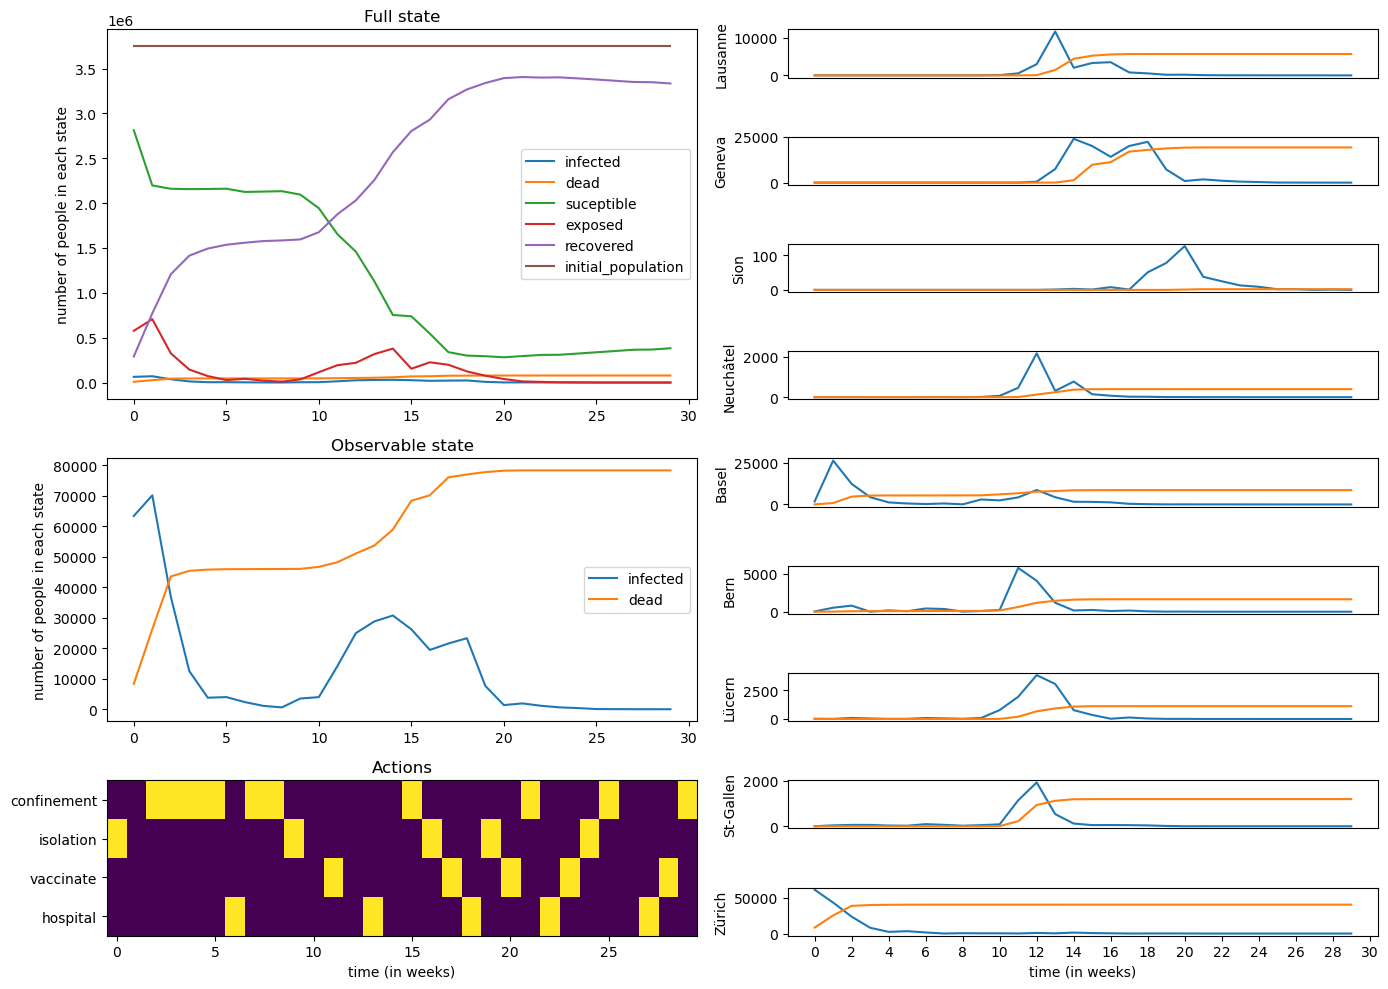

In [122]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax_leftstate.plot(y) for y in total.values()]
ax_leftstate.legend(total.keys())
ax_leftstate.set_title('Full state')
ax_leftstate.set_ylabel('number of people in each state')

[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state')
ax_leftobs.set_ylabel('number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('time (in weeks)')

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Zürich'].set_xlabel('time (in weeks)')
ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

fig.tight_layout()
plt.show()

### Determinism, pseudo-randomness and reproducibility
We ask you to ensure that your results are reproducible. To make sure this is the case you need to learn how to seed the environment, as well as the pytorch random number generator.

Making sure that we get the same initialization twice for the environment can be done by seeding the reset function (when resetting the environment). In the cell below we show how seeding the environment ensures episodes are reproductible.

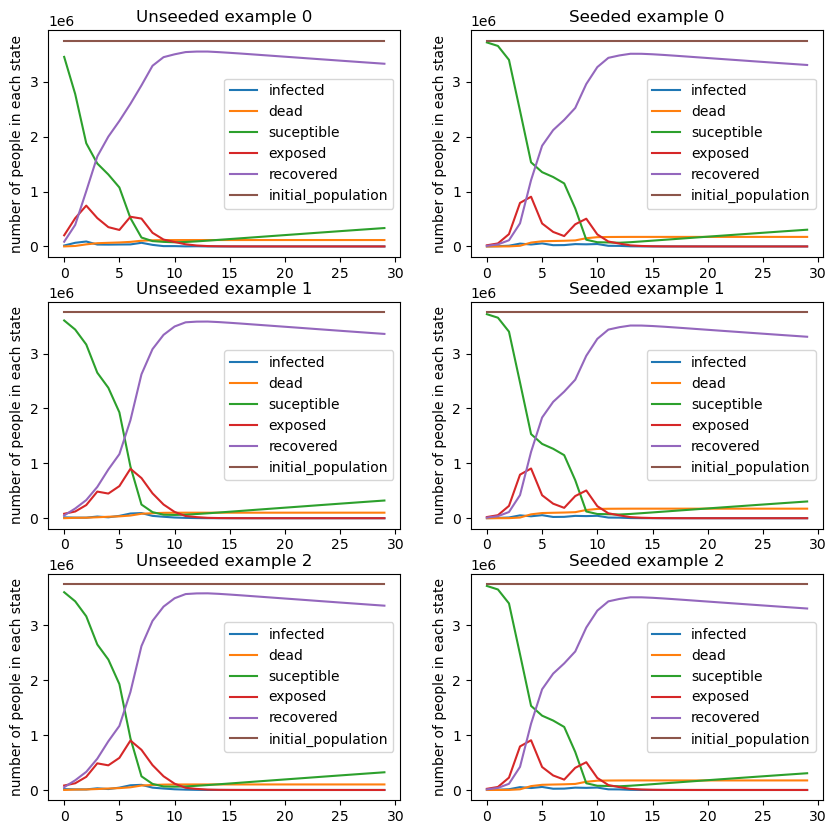

In [128]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

env = Env(  dyn, # We pass the dynamical model to the environment 
            action_space=None, # Here one could pass an openai gym action space that can then be sampled
            observation_space=None, # Here one could pass an openai gym obs space that can then be sampled
            )

action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }

fig, ax = plt.subplots(3,2,figsize=(10,10))

""" Run the simulations, unseeded"""
for trace in range(3):
    log = []
    finished = False
    obs, info = env.reset() # here it is not seeded
    for t in range(30):
        obs, R, finished, info = env.step(action) # always same actions
        log.append(info) # save the information dict for logging
        if finished:
            break
    """ Parse the logs """
    total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
    cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

    [ax[trace,0].plot(y) for y in total.values()]
    ax[trace,0].legend(total.keys())
    ax[trace,0].set_title(f'Unseeded example {trace}')
    ax[trace,0].set_ylabel('number of people in each state')


## TRAINING SCHEMA TO BE USED

seed = 0
""" Run the simulations, seeded"""
for trace in range(3):
    log = []
    finished = False
    obs, info = env.reset(seed)
    for t in range(30):
        obs, R, finished, info = env.step(action)
        log.append(info) # save the information dict for logging
        if finished:
            break
    """ Parse the logs """
    total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
    cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

    [ax[trace,1].plot(y) for y in total.values()]
    ax[trace,1].legend(total.keys())
    ax[trace,1].set_title(f'Seeded example {trace}')
    ax[trace,1].set_ylabel('number of people in each state')


To ensure reproducible training, we also must make sure that the parameters of our neural networks are initialized to the same values from one run to the next. To do so, we need to seed the pytorch random number generator. This is performed as follows:

In [129]:
print("Unseeded random number generation, using non-determinstic algs")
for _ in range(3):
    torch.use_deterministic_algorithms(False)
    print(f"    rnd : {torch.randint(0,10,(2,))}")
    
print("Seeded random number generation, using only determinstic algs")
for _ in range(3):
    torch.manual_seed(0)
    torch.use_deterministic_algorithms(True)
    print(f"    rnd : {torch.randint(0,10,(2,))}")

Unseeded random number generation, using non-determinstic algs
    rnd : tensor([2, 7])
    rnd : tensor([2, 9])
    rnd : tensor([7, 2])
Seeded random number generation, using only determinstic algs
    rnd : tensor([4, 9])
    rnd : tensor([4, 9])
    rnd : tensor([4, 9])


### Histogram functions
In order to facilitate the plotting of the evaluation runs, we give you an example function with pre-set bins so your results are easily comparable.

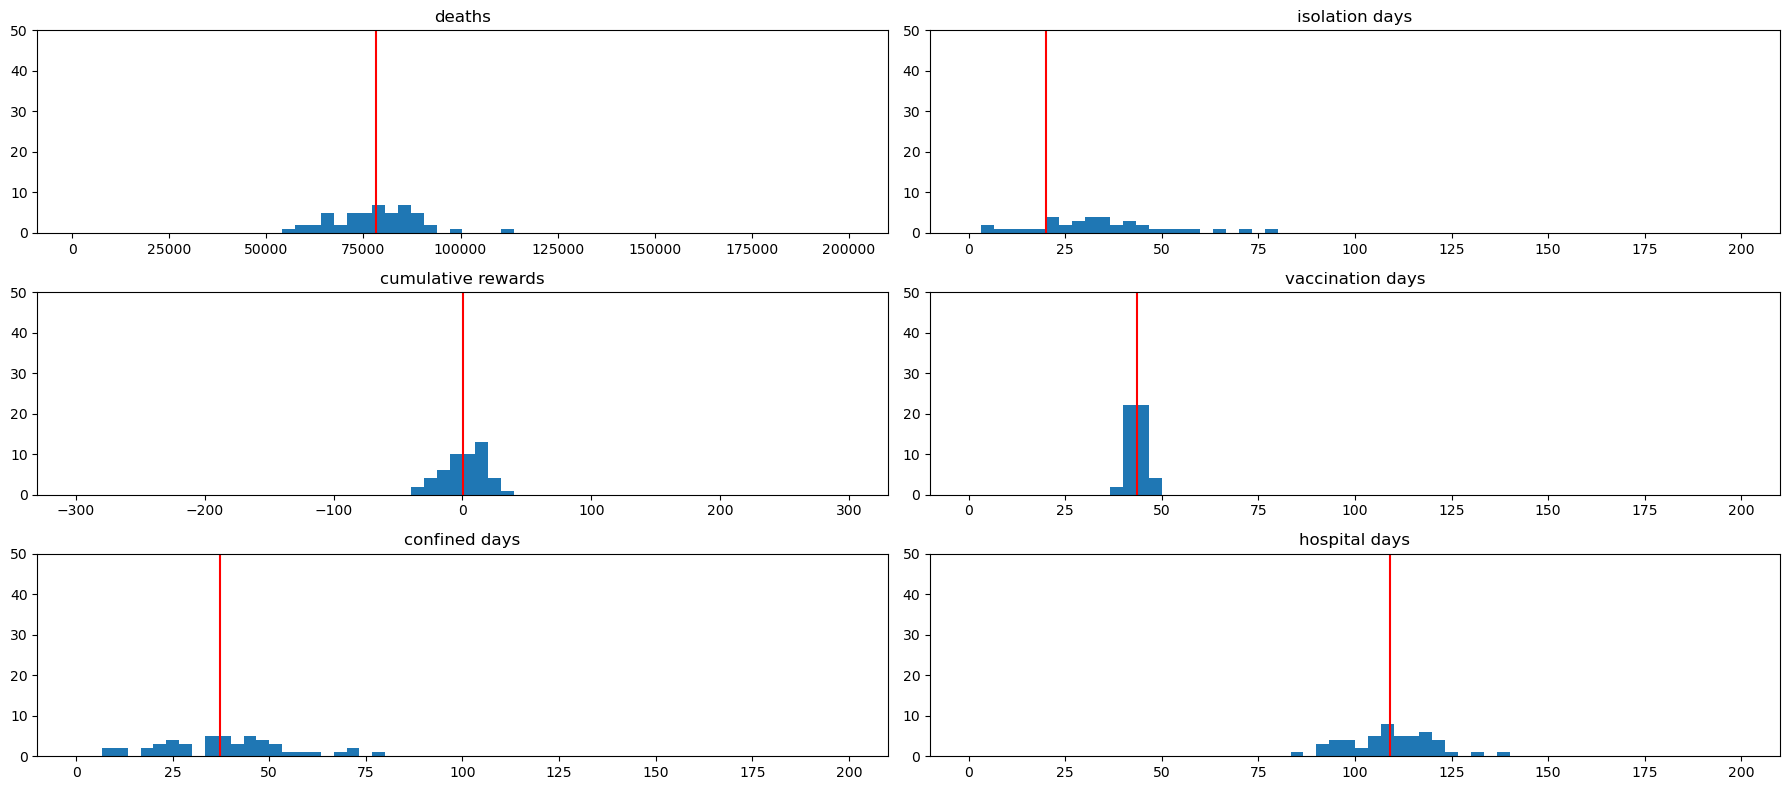

Average death number: 78140.77068683058
Average number of confined days: 37.14422369252274
Average number of isolation days: 37.14422369252274
Average number of additional hospital days: 109.02759309711888
Average number of vaccination: 43.63775634201759
Average cumulative reward: 0.15569087327368802


In [130]:
""" Create mock data """
deaths = np.random.normal(7.5e4,1e4,size=(50,1))
rewards = np.random.normal(2,20,size=(50,1))
conf_days = np.random.normal(40,20,size=(50,1))
isol_days = np.random.normal(22,30,size=(50,1))
vaccination_days = np.random.normal(44,2,size=(50,1))
hospital_days = np.random.normal(110,10,size=(50,1))

""" Plot example """
fig, ax = plt.subplots(3,2,figsize=(18,8))
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
hist_avg(ax[0,0], deaths,'deaths')
hist_avg(ax[1,0], rewards,'cumulative rewards')
hist_avg(ax[2,0], conf_days,'confined days')
hist_avg(ax[0,1], isol_days,'isolation days')
hist_avg(ax[1,1], vaccination_days,'vaccination days')
hist_avg(ax[2,1], hospital_days,'hospital days')
fig.tight_layout()
plt.show()

""" Print example """
print(f'Average death number: {np.mean(deaths)}')
print(f'Average number of confined days: {np.mean(conf_days)}')
print(f'Average number of isolation days: {np.mean(conf_days)}')
print(f'Average number of additional hospital days: {np.mean(hospital_days)}')
print(f'Average number of vaccination: {np.mean(vaccination_days)}')
print(f'Average cumulative reward: {np.mean(rewards)}')